<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_13_Autoencoders_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Linear vs Parameter Classes

In [2]:
# create an input and weight matrix
x = torch.rand(10, 50)  # a 10x50 matrix
print(x.shape)

torch.Size([10, 50])


In [3]:
W1 = nn.Parameter(torch.randn(128,50))
print(W1)

Parameter containing:
tensor([[-0.0966, -0.8687, -0.6562,  ...,  1.4465,  0.5177,  1.6065],
        [-0.6513,  0.5538, -0.1631,  ...,  0.7575,  0.0961, -0.5636],
        [ 0.9699, -0.5033,  0.9093,  ..., -0.9505,  0.7660,  1.3413],
        ...,
        [ 1.7499,  0.8344,  1.7626,  ..., -0.1816, -0.6612, -0.0324],
        [ 1.9008, -0.6410, -0.9488,  ..., -1.0135, -0.8009,  0.8647],
        [-0.1664, -1.6889,  0.6607,  ..., -0.6759,  0.2800,  0.6405]],
       requires_grad=True)


In [4]:
# Size and transpose of W1
print(W1.shape)
print(W1.t().shape)

torch.Size([128, 50])
torch.Size([50, 128])


In [5]:
# Compute the output of this layer: transpose W
y = x@W1.t()
print(y.shape)

torch.Size([10, 128])


In [6]:
# Now try with linear method
W2 = nn.Linear(128,50)
print(W2)

Linear(in_features=128, out_features=50, bias=True)


In [7]:
# This will not work
# print(W2.shape)
# We need to get the weights
print(W2.weight.shape)
print(W2.weight.t().shape)

torch.Size([50, 128])
torch.Size([128, 50])


In [8]:
# Compute the matrix multiplication: No transpose here
y = x @ (W2.weight)
print(y.shape)

torch.Size([10, 128])


In [9]:
# See all attributes of a class Linear
# dir(nn.Linear)
# docstring for Linear.forward
# ??nn.Linear.__init__()

# Autoencoders with Tied Weights

In [10]:
# Import the MNIST dataset coming with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

# keep the labels for later
labels = data[:,0]
data = data[:,1:]


# Normalize on range 0-1
dataNorm = data/np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

In [11]:
# Create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 128)

            # encoder layer
            # Be careful with dimensions here (check notes)
            self.enc = nn.Parameter(torch.randn(50,128)) # Not use nn.Linear

            # Latent Layer: No latent layer
            # self.lat = nn.Linear(50,250)

            # Decoder Layer
            self.dec = nn.Linear(128,784)

        # Forward Pass
        def forward(self,x):
            # Normal forward prop in first satge
            x = F.relu(self.input(x))

            # A parameter type is not  alinear type, so we do multuplication directly
            x = x.t() # transpose the input matrix
            # self.enc is a matrix this time
            x = F.relu(self.enc@x)

            # Sme for decoding layer, but needs to be transposed
            x = F.relu(self.enc.t()@x)
            x = x.t() # transpose it back

            y = torch.sigmoid(self.dec(x)) # data is normalized between 0-1, thus sigmoid
            return y

    # create model instance
    net = aenet()

    # Loss Function
    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [12]:
# Lets check whether the model works 
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


In [13]:
# Function to train the model
def function2trainTheModel():

    # Number of epochs
    numepochs = 10000

    # create new model instance
    net, lossfun, optimizer = createTheMNISTAE()

    losses = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # Select a random set of images: This is sort of minibatches, but bootstrapped
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx,:]

        # Forward Pass and Loss
        yHat = net(X)
        # Loss is difference of the whole data matrix
        loss = lossfun(yHat,X)

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Losses for each epoch
        losses[epochi] = loss.item()
    # End of epochs loop

    # The final output
    return losses, net

In [14]:
# Train the model
losses, net = function2trainTheModel()
print(f"The final loss is: {losses[-1]:.4f}")

The final loss is: 0.0151


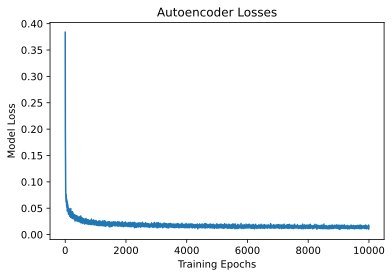

In [15]:
# Visualize the losses
plt.plot(losses)
plt.xlabel("Training Epochs")
plt.ylabel("Model Loss")
plt.title("Autoencoder Losses")
plt.show()

In [16]:
# Test the model with some data
X = dataT[:5,:]
yHat = net(X)

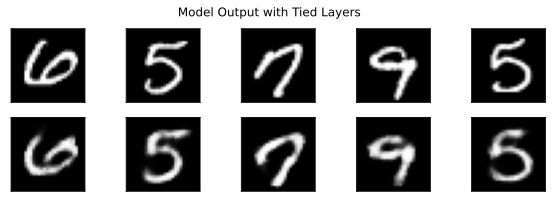

In [17]:
# Plot and see
fig,axs = plt.subplots(2,5, figsize=(10,3))

for i in range(5):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(yHat[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle("Model Output with Tied Layers")
plt.show()

## Add Noise to the Data

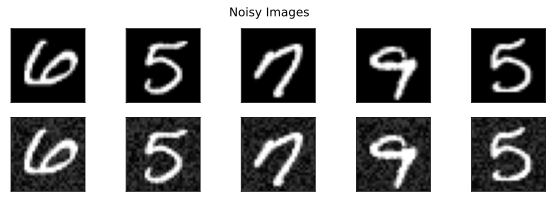

In [18]:
# Grab a small set of images
X = dataT[:10,:]

# Add noise to them
Xnoise = X + torch.rand_like(X)/4

# clip at 1 to avoid pixcel values greater than 1
Xnoise[Xnoise > 1] = 1

# Show the Noisy images
fig,axs = plt.subplots(2,5, figsize=(10,3))

for i in range(5):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(Xnoise[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle("Noisy Images")
plt.show()

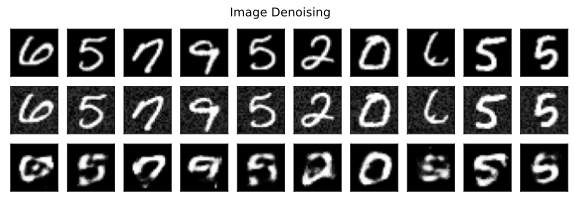

In [19]:
# Run through the model and see what happens
Y = net(Xnoise)

fig,axs = plt.subplots(3,10, figsize=(10,3))

for i in range(10):
    axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(Xnoise[i,:].view(28,28).detach(), cmap="gray")
    axs[2,i].imshow(Y[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
    axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle("Image Denoising")
plt.show()